<a href="https://colab.research.google.com/github/jtkernan7/DS-Unit-2-Classification-1/blob/master/JT_Kernan_DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [0]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.9MB/s 


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.float_format', '{:.2f}'.format)

In [0]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,Home_Court_advantage,opponent,seconds_remaining_in_period,made_last_shot,periods_remaining,seconds_remaining_game
game_date,,,,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.00,True,HOU,685,0.00,3,2845
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.00,True,HOU,571,0.00,3,2731
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.00,True,HOU,362,1.00,3,2522
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.00,True,HOU,589,0.00,2,2029
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.00,True,HOU,139,0.00,2,1579


In [0]:
df['shot_made_flag'].value_counts()

0    7357
1    6601
Name: shot_made_flag, dtype: int64

In [0]:
#feature engineering in next few cells

df['Home_Court_advantage'] = df['htm'] =='GSW'
df.head()

In [0]:
teams = df['htm'] + df['vtm']
df['opponent'] = teams.str.strip('GSW')

In [0]:
df['seconds_remaining_in_period'] = df['seconds_remaining'] + (df['minutes_remaining']*60)
df.head()

In [0]:
df['made_last_shot'] = df['shot_made_flag'].shift(1)
df['made_last_shot'].iloc[0] = 0 
# df.tail(10)

In [0]:
df['periods_remaining'] = 4-df['period']
df.loc[df.periods_remaining < 0, 'periods_remaining'] = 0
df['seconds_remaining_game'] = df['periods_remaining']*12*60 + df['seconds_remaining_in_period']


In [0]:
df = df.drop(['htm', 'vtm', 'period', 'minutes_remaining', 'seconds_remaining'], axis=1)

In [0]:
df.head()

In [0]:
train = df['2009':'2017-09-01']
val  = df['2017-09-02':'2018-09-01']
test = df['2018-09-02':]

In [0]:
print(train.shape, val.shape, test.shape)

(11081, 20) (1168, 20) (1709, 20)


In [0]:
target = 'shot_made_flag'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
#making baseline model from training set
majority_class = y_train.mode()[0]

In [0]:
y_pred = [majority_class]* len(y_train)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5272087356736757

In [0]:
#baseline model tested on validation set

y_pred = [majority_class]* len(y_val)


accuracy_score(y_val, y_pred)

0.5162671232876712

In [0]:
# Make pipeline!
#ordinal encoded and random forest
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)


#Part 2 Below


In [0]:
#validation accuracy
pipeline.fit(X_train, y_train)
print(pipeline.score(X_val, y_val))

0.603595890410959


In [0]:
#test accuracy
print(pipeline.score(X_test, y_test))

0.6249268578115857


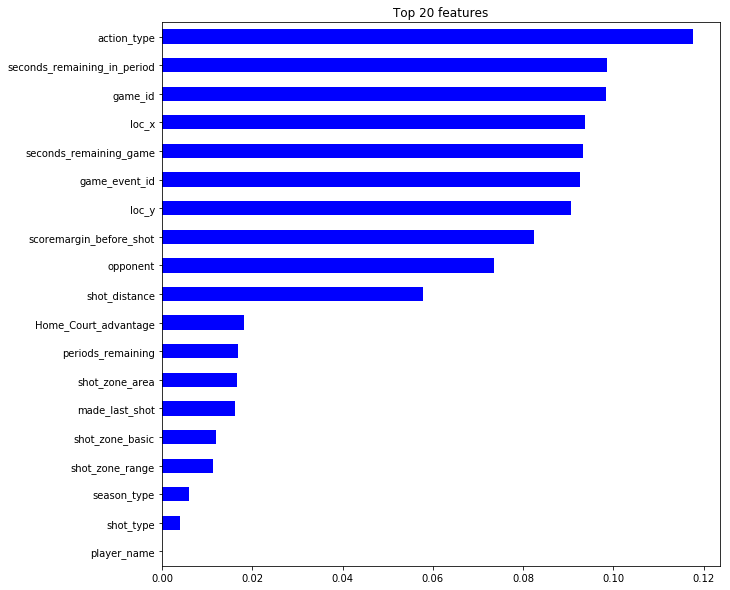

In [0]:
# Get feature importances
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

#stretch

In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

from sklearn.utils.multiclass import unique_labels

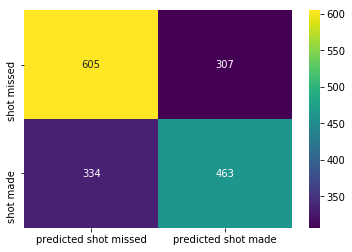

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = ['predicted shot missed', 'predicted shot made']
    index = ['shot missed', 'shot made']
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap = 'viridis')
    
plot_confusion_matrix(y_test, y_pred);

In [0]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       912
           1       0.60      0.58      0.59       797

    accuracy                           0.62      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.62      0.62      0.62      1709



This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [0]:
#accuracacy

correct_predictions = 85 + 36
total_predictions = correct_predictions + 8 + 58

correct_predictions / total_predictions

0.6470588235294118

In [0]:
#precision 

correct_positive = 36
total_predictions_positive = 36 + 58 

precision = correct_positive / total_predictions_positive
precision

0.3829787234042553

In [0]:
#recall 

actual_positive = 36 + 8

recall = correct_positive / actual_positive
recall

0.8181818181818182

#Stretch

In [0]:
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

0.5217391304347826